In [1]:
import os
import cv2
import dlib
import math
import numpy as np

import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
# import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
np.random.seed(42)
DATA_PATH = "D://Downloads/figma//CK+48//"
# BASE_PATH = "D://Downloads/figma/shape_predictor_68_face_landmarks.dat"


In [3]:
class_count = {}
for dir_ in os.listdir(DATA_PATH):
    count = 0
    for f in os.listdir(DATA_PATH + dir_ + "/"):
        count += 1

    class_count[dir_] = count
    print(f"{dir_} has {count} number of images")

total_images = sum(class_count.values())
print(f"\ntotal images are {total_images}")

anger has 135 number of images
fear has 75 number of images
happy has 207 number of images
sadness has 84 number of images
surprise has 249 number of images

total images are 750


In [4]:
TOP_EMOTIONS = ["happy", "fear", "sadness", "anger", "surprise"]

for k,v in class_count.items():
    if not k in TOP_EMOTIONS:
        total_images -= v

total_images

750

In [5]:
img_arr = np.empty(shape=(total_images,48,48,1))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
label = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        print(f"loading {dir_} images to numpy arrays")
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img_arr[i] = np.expand_dims(cv2.imread(DATA_PATH + dir_ + "/" + f, 0), axis=2)
            img_label[i] = label
            i += 1
        label_to_text[label] = dir_
        label += 1

img_label = to_categorical(img_label)
img_arr.shape, img_label.shape

loading anger images to numpy arrays


loading fear images to numpy arrays
loading happy images to numpy arrays
loading sadness images to numpy arrays
loading surprise images to numpy arrays


((750, 48, 48, 1), (750, 5))

In [6]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label
label_to_text

{0: 'anger', 1: 'fear', 2: 'happy', 3: 'sadness', 4: 'surprise'}

In [7]:
img_arr = img_arr / 255.

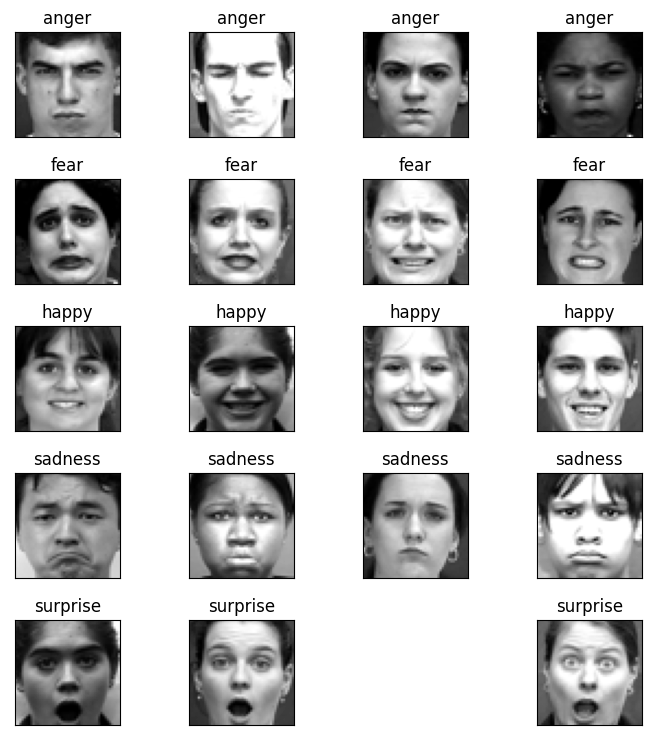

In [8]:
num_emotions = len(TOP_EMOTIONS)
fig = pyplot.figure(1, (num_emotions*1.5, num_emotions*1.5))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:,k]==1)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(num_emotions,4,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label, train_size=0.7, stratify=img_label, shuffle=True, random_state=42)



In [10]:
def build_dcnn(input_shape, num_classes):
    model_in = Input(shape=input_shape, name="input")
    
    conv2d_1 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(batchnorm_2)
    dropout_1 = Dropout(0.3, name='dropout_1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',z 
        kernel_initializer='he_normal',
        name='conv2d_4'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(batchnorm_4)
    dropout_2 = Dropout(0.3, name='dropout_2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(batchnorm_6)
    dropout_3 = Dropout(0.3, name='dropout_3')(maxpool2d_3)

    flatten = Flatten(name='flatten')(dropout_3)
    dense_1 = Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7')(dense_1)
    dropout_4 = Dropout(0.4, name='dropout_4')(batchnorm_7)

    model_out = Dense(
        num_classes,
        activation='softmax',
        name='out_layer'
    )(dropout_4)

    model = Model(inputs=model_in, outputs=model_out, name="DCNN")
    
    return model

In [11]:
INPUT_SHAPE = (48, 48, 1)
optim = optimizers.Adam(0.001)

model = build_dcnn(input_shape=(48,48,1), num_classes=len(label_to_text))
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='model.png')


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00008,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="model.h5",
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        mode="max"
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.4,
    patience=6,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    checkpoint,
    lr_scheduler
]

batch_size = 10
epochs = 60

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [14]:
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

d:\Downloads\Emotion Detection\Emotion_Detection_CNN-main\.venv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
52/52 [==============================] - 17s 301ms/step - loss: 1.9034 - accuracy: 0.4076 - val_loss: 2.8730 - val_accuracy: 0.4044

Epoch 00001: val_accuracy improved from -inf to 0.40444, saving model to model_dcnn.keras
Epoch 2/60
52/52 [==============================] - 14s 270ms/step - loss: 1.4576 - accuracy: 0.4952 - val_loss: 4.6551 - val_accuracy: 0.2978

Epoch 00002: val_accuracy did not improve from 0.40444
Epoch 3/60
52/52 [==============================] - 14s 269ms/step - loss: 1.1287 - accuracy: 0.6076 - val_loss: 3.2962 - val_accuracy: 0.4756

Epoch 00003: val_accuracy improved from 0.40444 to 0.47556, saving model to model_dcnn.keras
Epoch 4/60
52/52 [==============================] - 14s 266ms/step - loss: 1.0148 - accuracy: 0.6686 - val_loss: 0.8802 - val_accuracy: 0.6933

Epoch 00004: val_accuracy improved from 0.47556 to 0.69333, saving model to model_dcnn.keras
Epoch 5/60
52/52 [==============================] - 14s 267ms/step - loss: 0.9390 - accuracy:

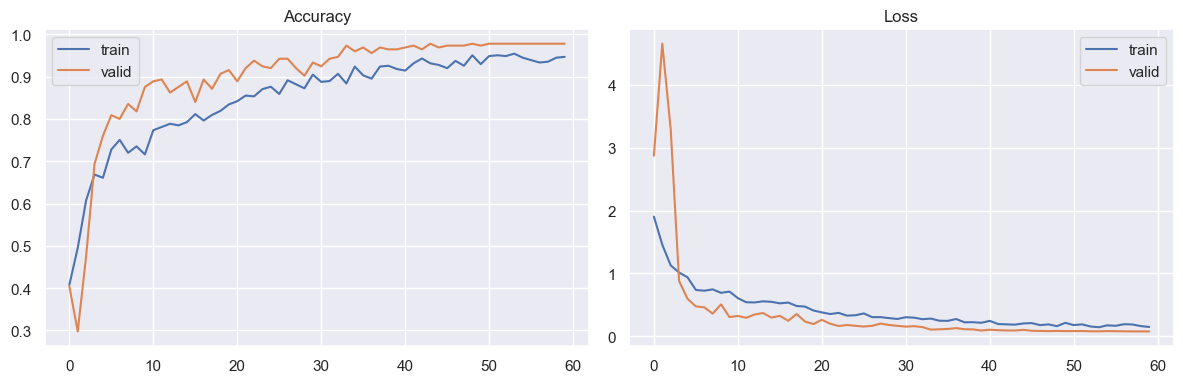

In [15]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.history['accuracy'], label='train')
sns.lineplot(history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.history['loss'], label='train')
sns.lineplot(history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('DCNN.png')
pyplot.show()

test accuracy: 97.7778 %


              precision    recall  f1-score   support

       anger       0.93      0.95      0.94        40
        fear       1.00      1.00      1.00        23
       happy       1.00      1.00      1.00        62
     sadness       0.92      0.88      0.90        25
    surprise       1.00      1.00      1.00        75

    accuracy                           0.98       225
   macro avg       0.97      0.97      0.97       225
weighted avg       0.98      0.98      0.98       225



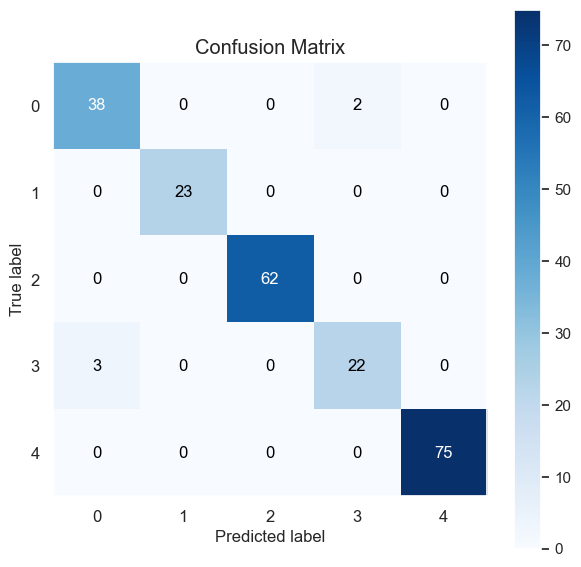

In [16]:
yhat_test = model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_model3pipes.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")
# {0: 'anger', 1: 'fear', 2: 'happy', 3: 'sadness', 4: 'surprise'}
emotions = ['anger','fear','happy','sadness','surprise']
print(classification_report(ytest_, yhat_test,target_names=emotions))